# FraudGuard - Model Training & Comparison

**Ziel:** ML-Modell trainieren und mit Rule-Based System vergleichen

## Inhalt
1. Dataset laden (mit Regeln)
2. Feature Engineering
3. ML-Only Training (XGBoost ohne Rules)
4. Evaluation & Vergleich
5. Feature Importance
6. Predictions speichern

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings

import sys
sys.path.append('..')
from src.features import engineer_features, select_ml_features, prepare_for_ml
from src.utils import temporal_train_test_split, print_fraud_stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Imports successful")

✓ Imports successful


## 1. Dataset laden

**Lade gespeicherte Daten aus Notebook 02 (mit Regeln!)**

In [2]:
# Lade Daten mit Regeln
df = pd.read_csv('../data/processed/transactions_with_rules.csv')

# Parse datetime columns (wichtig!)
df['trans_datetime'] = pd.to_datetime(df['trans_datetime'])
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

print(f"Loaded: {len(df):,} transactions")
print(f"Columns: {len(df.columns)}")
print_fraud_stats(df)

Loaded: 100,000 transactions
Columns: 38
FRAUD STATISTICS
Total Transactions: 100,000
Fraud Cases:        990
Fraud Rate:         0.99%
Legitimate Cases:   99,010


In [3]:
# Überblick: Vorhandene Spalten
print("\nAvailable columns:")
print(f"Total: {len(df.columns)}")
print(f"\nSample columns: {list(df.columns[:10])}")


Available columns:
Total: 38

Sample columns: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street']


## 2. Feature Engineering

In [4]:
# Engineer Features
print("Engineering features...\n")
df = engineer_features(df)

print(f"\n✓ DataFrame now has {len(df.columns)} columns")

Engineering features...

Engineering features for ML...
  1. Time features...
  2. Geographic features...
  3. Aggregated features...
  4. Deviation features...
  5. Categorical features...
✓ Feature engineering complete: 69 total columns

✓ DataFrame now has 69 columns


In [5]:
# Beispiel: Erste Zeilen mit neuen Features (NACH Feature Engineering!)
feature_cols_sample = ['amt', 'hour', 'cust_merch_distance', 'avg_amount_expanding', 
                       'amount_vs_avg_ratio', 'age', 'is_fraud']

# Nur Spalten die existieren
available_cols = [col for col in feature_cols_sample if col in df.columns]
print(f"\nShowing {len(available_cols)} sample features:")
df[available_cols].head(10)


Showing 6 sample features:


,amt,hour,avg_amount_expanding,amount_vs_avg_ratio,age,is_fraud
0,7.27,12,7.270000,0.879081,32.870637,0
1,52.94,8,30.105000,1.701977,32.873374,0
2,82.08,8,47.430000,1.694817,32.873374,0
3,34.79,12,44.270000,0.768500,32.873374,0
4,27.18,13,40.852000,0.649431,32.873374,0
5,6.87,13,35.188333,0.189840,32.876112,0
6,8.43,17,31.365714,0.260461,32.876112,0
7,117.11,13,42.083750,2.718194,32.878850,0
8,26.74,21,40.378889,0.646223,32.878850,0
9,105.20,0,46.861000,2.198032,32.881588,0


## 3. Train/Test Split

**Wichtig: Temporal Split!** (Erste 70% = Train, letzte 30% = Test)

In [6]:
# Temporal Split
train_df, test_df = temporal_train_test_split(df, time_col='trans_date_trans_time', train_ratio=0.7)

print(f"\nTrain fraud rate: {train_df['is_fraud'].mean():.2%}")
print(f"Test fraud rate:  {test_df['is_fraud'].mean():.2%}")

Train: 70,000 rows (70%)
Test:  30,000 rows (30%)

Train fraud rate: 0.97%
Test fraud rate:  1.03%


## 4. ML-Only Training (ohne Rule-Features)

**Vergleich: Kann ML ohne Regeln gut performen?**

In [7]:
# Feature Selection: ML-ONLY (keine Rules!)
ml_features = select_ml_features(df, include_rules=False)

print(f"\nSelected features: {ml_features[:10]}...")
print(f"Total: {len(ml_features)} features")


Selected 26 features for ML:
  Mode: ML-ONLY (without rule features)

Selected features: ['amt', 'hour', 'day_of_week', 'is_weekend', 'is_night', 'is_morning', 'is_afternoon', 'is_evening', 'distance_to_prev', 'velocity_kmh']...
Total: 26 features


In [8]:
# Prepare Training Data
X_train, y_train = prepare_for_ml(train_df, ml_features)
X_test, y_test = prepare_for_ml(test_df, ml_features)


Prepared for ML:
  Features: (70000, 26)
  Labels: (70000,)
  Fraud rate: 0.97%

Prepared for ML:
  Features: (30000, 26)
  Labels: (30000,)
  Fraud rate: 1.03%


### Handle Class Imbalance mit SMOTE

In [9]:
print("Applying SMOTE for class balancing...\n")

# SMOTE: Oversample minority class
smote = SMOTE(random_state=42, sampling_strategy=0.3)  # 30% fraud after SMOTE
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original train fraud rate: {y_train.mean():.2%}")
print(f"After SMOTE fraud rate:    {y_train_balanced.mean():.2%}")
print(f"Train samples after SMOTE: {len(X_train_balanced):,}")

Applying SMOTE for class balancing...

Original train fraud rate: 0.97%
After SMOTE fraud rate:    23.08%
Train samples after SMOTE: 90,114


### Feature Scaling

In [10]:
# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled")

✓ Features scaled


### Train XGBoost

In [11]:
print("Training XGBoost (ML-Only)...\n")

# XGBoost Classifier
model_ml = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    verbosity=1
)

# Train
model_ml.fit(
    X_train_scaled,
    y_train_balanced,
    eval_set=[(X_test_scaled, y_test)],
    verbose=50
)

print("\n✓ Training complete")

Training XGBoost (ML-Only)...

[0]	validation_0-logloss:0.24851
[50]	validation_0-logloss:0.02512
[100]	validation_0-logloss:0.01423
[150]	validation_0-logloss:0.01253
[200]	validation_0-logloss:0.01222
[250]	validation_0-logloss:0.01227
[299]	validation_0-logloss:0.01241

✓ Training complete


## 5. Evaluation: ML-Only

In [12]:
# Predictions
y_pred_ml = model_ml.predict(X_test_scaled)
y_proba_ml = model_ml.predict_proba(X_test_scaled)[:, 1]

# Metrics
precision_ml = precision_score(y_test, y_pred_ml)
recall_ml = recall_score(y_test, y_pred_ml)
f1_ml = f1_score(y_test, y_pred_ml)
roc_auc_ml = roc_auc_score(y_test, y_proba_ml)

print("="*60)
print("ML-ONLY PERFORMANCE")
print("="*60)
print(f"Precision: {precision_ml:.3f}")
print(f"Recall:    {recall_ml:.3f}")
print(f"F1-Score:  {f1_ml:.3f}")
print(f"ROC-AUC:   {roc_auc_ml:.3f}")
print("="*60)

ML-ONLY PERFORMANCE
Precision: 0.951
Recall:    0.754
F1-Score:  0.841
ROC-AUC:   0.992


In [13]:
# Classification Report
print("\nClassification Report (ML-Only):")
print(classification_report(y_test, y_pred_ml, target_names=['Legitimate', 'Fraud']))


Classification Report (ML-Only):
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     29691
       Fraud       0.95      0.75      0.84       309

    accuracy                           1.00     30000
   macro avg       0.97      0.88      0.92     30000
weighted avg       1.00      1.00      1.00     30000



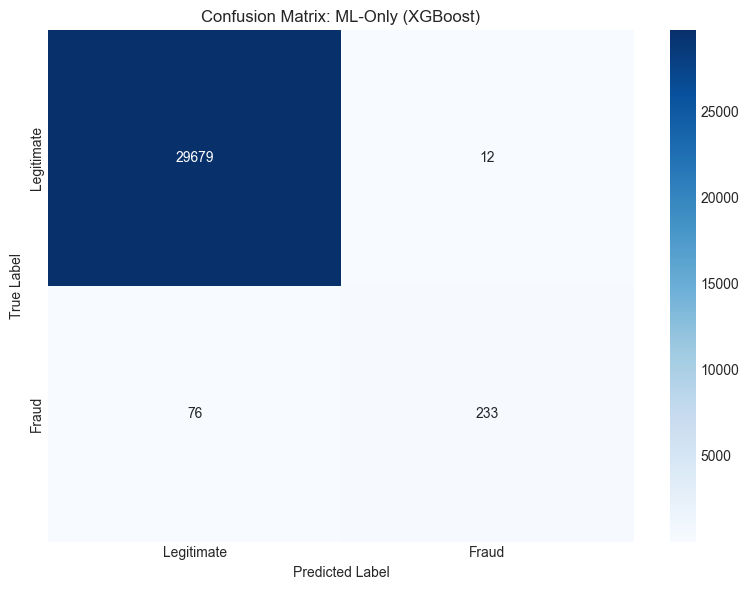

TN: 29,679 | FP: 12
FN: 76 | TP: 233


In [14]:
# Confusion Matrix
cm_ml = confusion_matrix(y_test, y_pred_ml)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix: ML-Only (XGBoost)')
plt.tight_layout()
plt.show()

print(f"TN: {cm_ml[0,0]:,} | FP: {cm_ml[0,1]:,}")
print(f"FN: {cm_ml[1,0]:,} | TP: {cm_ml[1,1]:,}")

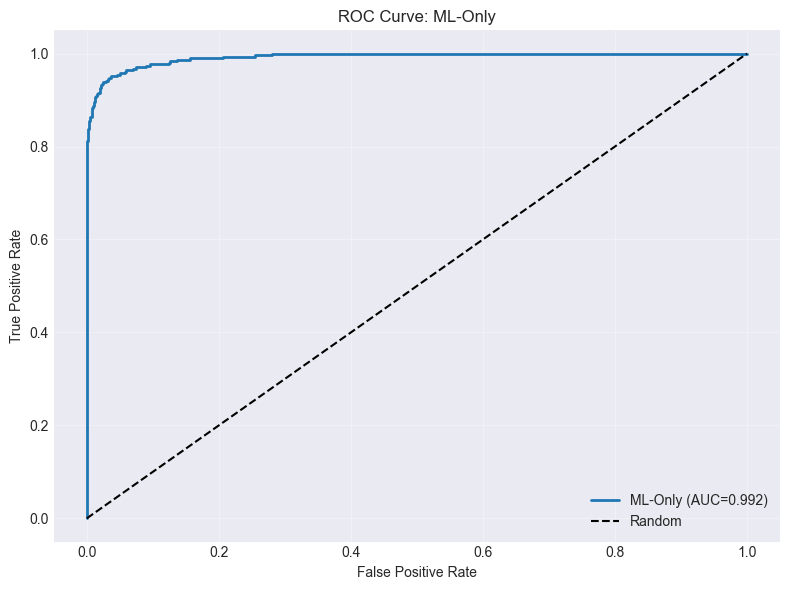

In [15]:
# ROC Curve
fpr_ml, tpr_ml, _ = roc_curve(y_test, y_proba_ml)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ml, tpr_ml, linewidth=2, label=f'ML-Only (AUC={roc_auc_ml:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: ML-Only')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Feature Importance

In [16]:
# Feature Importance
importance_df = pd.DataFrame({
    'Feature': ml_features,
    'Importance': model_ml.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features (ML-Only):")
print(importance_df.head(15).to_string(index=False))


Top 15 Most Important Features (ML-Only):
             Feature  Importance
                 amt    0.204069
        is_afternoon    0.106792
std_amount_expanding    0.098548
          is_morning    0.090153
avg_amount_expanding    0.073327
            is_night    0.058827
       amount_zscore    0.048400
          is_weekend    0.046128
 amount_vs_avg_ratio    0.041600
            gender_F    0.036878
          is_evening    0.036125
            gender_M    0.035470
  category_frequency    0.025055
                hour    0.023730
   max_amount_so_far    0.021058


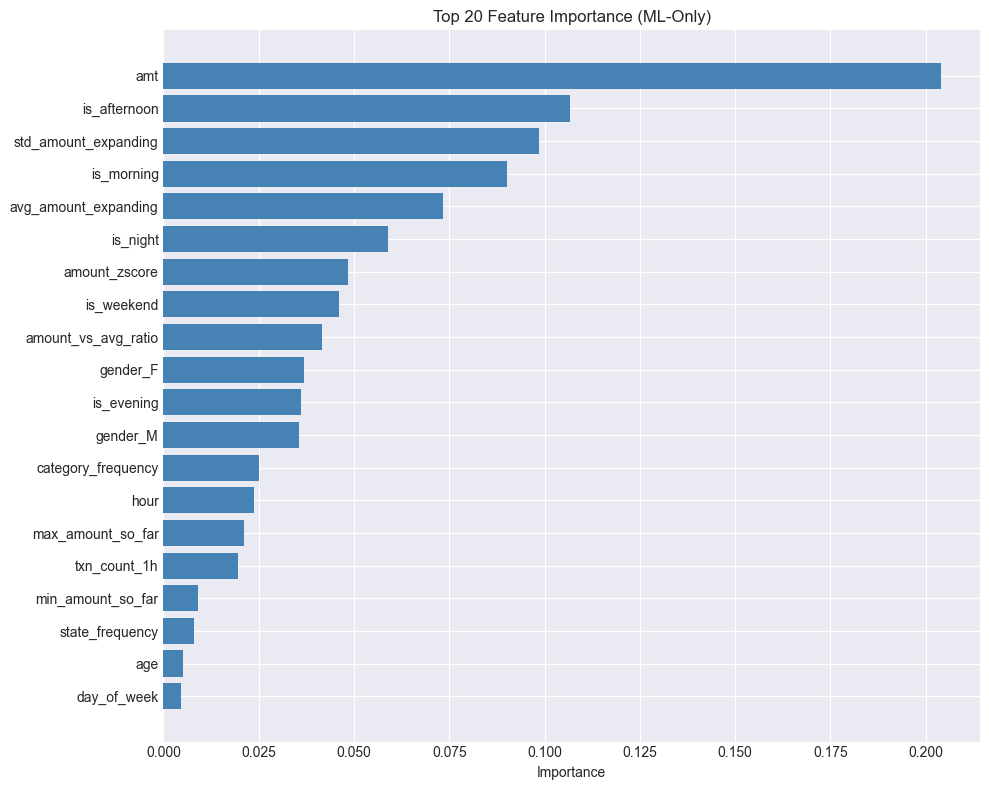

In [17]:
# Visualisierung
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (ML-Only)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Vergleich: Rule-Based vs. ML-Only

**Holen wir die Rule-Based Performance aus Notebook 02**

In [18]:
# Rule-Based Predictions (aus Test Set)
y_pred_rules = test_df['rule_based_prediction'].values

# Metrics
precision_rules = precision_score(y_test, y_pred_rules)
recall_rules = recall_score(y_test, y_pred_rules)
f1_rules = f1_score(y_test, y_pred_rules)

print("="*60)
print("RULE-BASED PERFORMANCE (Baseline)")
print("="*60)
print(f"Precision: {precision_rules:.3f}")
print(f"Recall:    {recall_rules:.3f}")
print(f"F1-Score:  {f1_rules:.3f}")
print(f"ROC-AUC:   N/A (no probability scores)")
print("="*60)

RULE-BASED PERFORMANCE (Baseline)
Precision: 0.077
Recall:    0.502
F1-Score:  0.134
ROC-AUC:   N/A (no probability scores)


In [19]:
# Comparison Table
comparison = pd.DataFrame({
    'Approach': ['Rule-Based', 'ML-Only (XGBoost)'],
    'Precision': [precision_rules, precision_ml],
    'Recall': [recall_rules, recall_ml],
    'F1-Score': [f1_rules, f1_ml],
    'ROC-AUC': [np.nan, roc_auc_ml]
})

# Improvement
comparison['F1_Improvement'] = [
    0,
    ((f1_ml - f1_rules) / f1_rules * 100)
]

print("\n" + "="*80)
print("COMPARISON: RULE-BASED vs. ML-ONLY")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)
print(f"\n✓ ML-Only improves F1-Score by {comparison.iloc[1]['F1_Improvement']:.1f}% over Rule-Based!")
print("="*80)


COMPARISON: RULE-BASED vs. ML-ONLY
         Approach  Precision   Recall  F1-Score  ROC-AUC  F1_Improvement
       Rule-Based   0.077345 0.501618  0.134025      NaN        0.000000
ML-Only (XGBoost)   0.951020 0.754045  0.841155   0.9924      527.610341

✓ ML-Only improves F1-Score by 527.6% over Rule-Based!


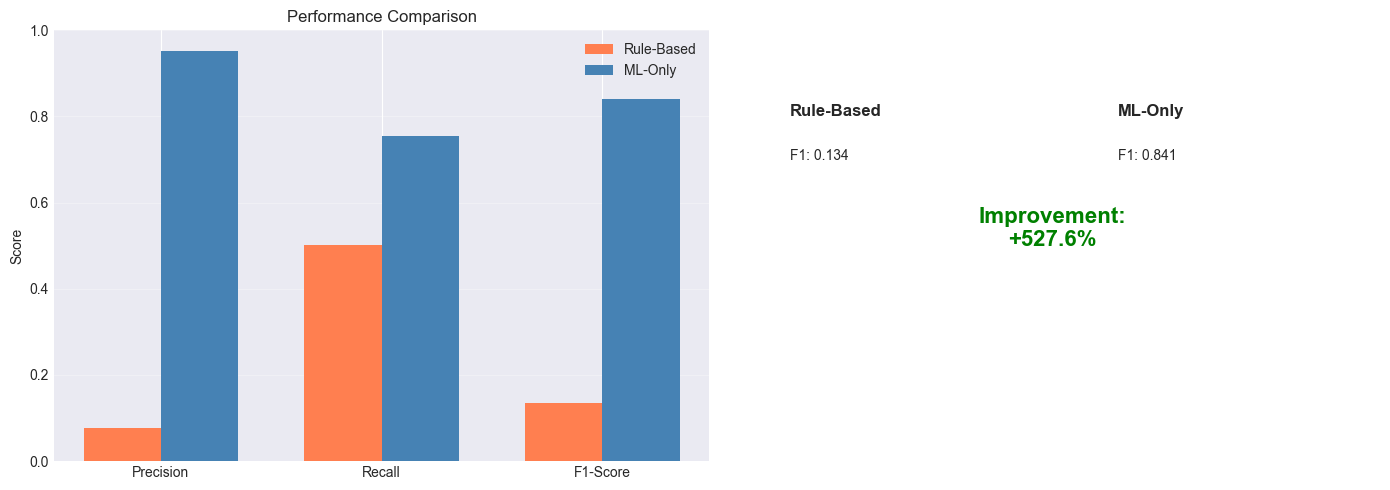

In [20]:
# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar Chart: Metrics
metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_to_plot))
width = 0.35

axes[0].bar(x - width/2, comparison.iloc[0][metrics_to_plot].values, 
           width, label='Rule-Based', color='coral')
axes[0].bar(x + width/2, comparison.iloc[1][metrics_to_plot].values, 
           width, label='ML-Only', color='steelblue')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')

# Confusion Matrices side-by-side
cm_rules = confusion_matrix(y_test, y_pred_rules)

axes[1].text(0.1, 0.8, 'Rule-Based', fontsize=12, weight='bold', transform=axes[1].transAxes)
axes[1].text(0.1, 0.7, f'F1: {f1_rules:.3f}', fontsize=10, transform=axes[1].transAxes)

axes[1].text(0.6, 0.8, 'ML-Only', fontsize=12, weight='bold', transform=axes[1].transAxes)
axes[1].text(0.6, 0.7, f'F1: {f1_ml:.3f}', fontsize=10, transform=axes[1].transAxes)

improvement = ((f1_ml - f1_rules) / f1_rules * 100)
axes[1].text(0.5, 0.5, f'Improvement:\n+{improvement:.1f}%', 
            fontsize=16, weight='bold', ha='center', transform=axes[1].transAxes,
            color='green')

axes[1].axis('off')

plt.tight_layout()
plt.show()

## 8. Save Model & Predictions

In [21]:
# Save Model
joblib.dump(model_ml, '../models/xgboost_ml_only.pkl')
joblib.dump(scaler, '../models/scaler_ml_only.pkl')
joblib.dump(ml_features, '../models/ml_features.pkl')

print("✓ Model saved to ../models/")

✓ Model saved to ../models/


In [22]:
# Create predictions DataFrame for Dashboard
predictions_df = test_df.copy()

# Add ML predictions
predictions_df['ml_prediction'] = y_pred_ml
predictions_df['ml_probability'] = y_proba_ml

# Risk Level basierend auf Probability
def assign_risk_level(prob):
    if prob >= 0.7:
        return 'High'
    elif prob >= 0.3:
        return 'Medium'
    else:
        return 'Low'

predictions_df['ml_risk_level'] = predictions_df['ml_probability'].apply(assign_risk_level)

# Speichern
predictions_df.to_csv('../data/processed/predictions_comparison.csv', index=False)

print(f"✓ Predictions saved for {len(predictions_df):,} transactions")
print(f"  File: ../data/processed/predictions_comparison.csv")

✓ Predictions saved for 30,000 transactions
  File: ../data/processed/predictions_comparison.csv


## Summary

In [23]:
print("\n" + "="*80)
print("FRAUDGUARD - TRAINING SUMMARY")
print("="*80)
print(f"\nDataset:")
print(f"  Total: {len(df):,} transactions")
print(f"  Train: {len(train_df):,} | Test: {len(test_df):,}")
print(f"  Fraud Rate: {df['is_fraud'].mean():.2%}")

print(f"\nApproaches Compared:")
print(f"  1. Rule-Based (7 business rules, ≥2 threshold)")
print(f"  2. ML-Only (XGBoost with {len(ml_features)} features)")

print(f"\nResults:")
print(f"  Rule-Based F1: {f1_rules:.3f}")
print(f"  ML-Only F1:    {f1_ml:.3f}")
print(f"  Improvement:   +{((f1_ml - f1_rules) / f1_rules * 100):.1f}%")

print(f"\nFiles Saved:")
print(f"  ✓ Model: xgboost_ml_only.pkl")
print(f"  ✓ Scaler: scaler_ml_only.pkl")
print(f"  ✓ Predictions: predictions_comparison.csv")

print(f"\nNext Steps:")
print(f"  → Build Streamlit Dashboard (app.py)")
print(f"  → Visualize comparison interactively")
print("="*80)


FRAUDGUARD - TRAINING SUMMARY

Dataset:
  Total: 100,000 transactions
  Train: 70,000 | Test: 30,000
  Fraud Rate: 0.99%

Approaches Compared:
  1. Rule-Based (7 business rules, ≥2 threshold)
  2. ML-Only (XGBoost with 26 features)

Results:
  Rule-Based F1: 0.134
  ML-Only F1:    0.841
  Improvement:   +527.6%

Files Saved:
  ✓ Model: xgboost_ml_only.pkl
  ✓ Scaler: scaler_ml_only.pkl
  ✓ Predictions: predictions_comparison.csv

Next Steps:
  → Build Streamlit Dashboard (app.py)
  → Visualize comparison interactively
